In [1]:
! pip install fipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.0/449.0 kB 4.0 MB/s eta 0:00:00


In [2]:
from fipy import CellVariable, Grid2D, DiffusionTerm, TransientTerm, Viewer
import numpy as np


In [3]:
# Define mesh
L = 10e-6  # 10 µm domain
nx = 200
ny = 200
mesh = Grid2D(dx=L/nx, dy=L/ny, nx=nx, ny=ny)

# Define spatial coordinates
x, y = mesh.cellCenters
r = np.sqrt((x - L/2)**2 + (y - L/2)**2)  # radial distance from center


In [4]:
# Define concentric regions
core_radius = 2e-6
shell1_radius = 3e-6
shell2_radius = 4e-6

# Create masks for layers
core = (r < core_radius)
shell1 = (r >= core_radius) & (r < shell1_radius)
shell2 = (r >= shell1_radius) & (r < shell2_radius)


In [5]:
D_core = 1e-9       # m²/s
D_shell = 1e-12     # m²/s

# Spatially varying diffusion
D = np.where(core, D_core, np.where(shell1, D_shell, D_shell))


In [6]:
# Create variable for concentration
C = CellVariable(name="concentration", mesh=mesh, value=0.0)

# Boundary condition: high concentration at center (simulate dye injection)
C.constrain(1.0, where=core)

# Define equation
eq = TransientTerm() == DiffusionTerm(coeff=D)


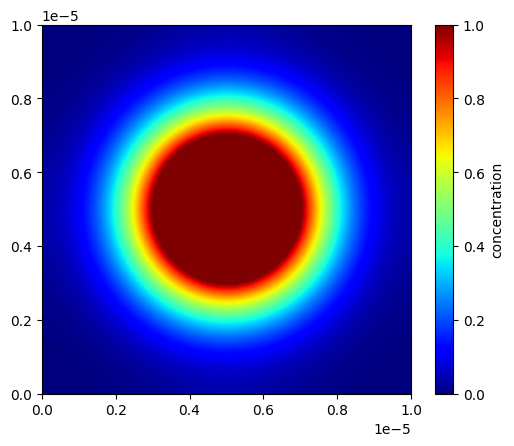

In [7]:
from fipy import CellVariable, Grid2D, DiffusionTerm, TransientTerm, Viewer
import numpy as np

# Define mesh
L = 10e-6
nx = 200
ny = 200
mesh = Grid2D(dx=L/nx, dy=L/ny, nx=nx, ny=ny)

# Define coordinates
x, y = mesh.cellCenters
r = np.sqrt((x - L/2)**2 + (y - L/2)**2)

# Define regions
core_radius = 2e-6
shell1_radius = 3e-6
shell2_radius = 4e-6

core = (r < core_radius)
shell1 = (r >= core_radius) & (r < shell1_radius)
shell2 = (r >= shell1_radius) & (r < shell2_radius)

# Define diffusion coefficients
D_core = 1e-9
D_shell = 1e-12

# ✅ Create FiPy CellVariable for D
D_value = np.where(core, D_core, np.where(shell1, D_shell, D_shell))
D = CellVariable(mesh=mesh, value=D_value)

# Define concentration
C = CellVariable(name="concentration", mesh=mesh, value=0.0)

# Boundary condition (high concentration in core)
C.constrain(1.0, where=core)

# Define PDE
eq = TransientTerm() == DiffusionTerm(coeff=D)

# Time stepping
time_step = 1e-3
steps = 1000

viewer = Viewer(vars=(C,), datamin=0, datamax=1)

for step in range(steps):
    eq.solve(var=C, dt=time_step)
    if step % 50 == 1:
        viewer.plot()


In [10]:
np.savetxt("myelin_diffusion_profile.txt", np.c_[x, y, C.value])


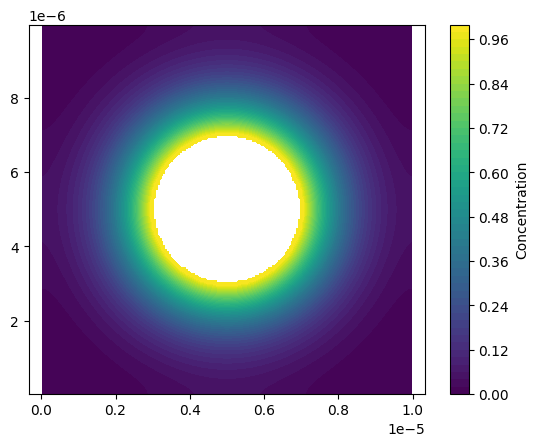

In [11]:
import matplotlib.pyplot as plt

plt.tricontourf(x, y, C.value, levels=50, cmap='viridis')
plt.colorbar(label='Concentration')
plt.axis('equal')
plt.show()


Time-stepping finished.
Numerical flux (per unit axial length) J_numeric = 1.3567036111989923e-11
Analytic flux (per unit axial length) J_analytic = 6.401469091228763e-12
Relative error (numeric vs analytic): 1.119e+00


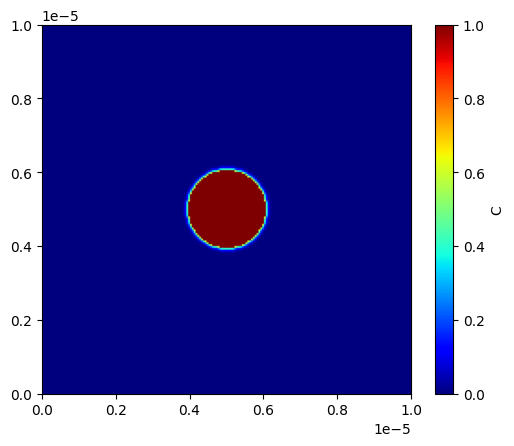

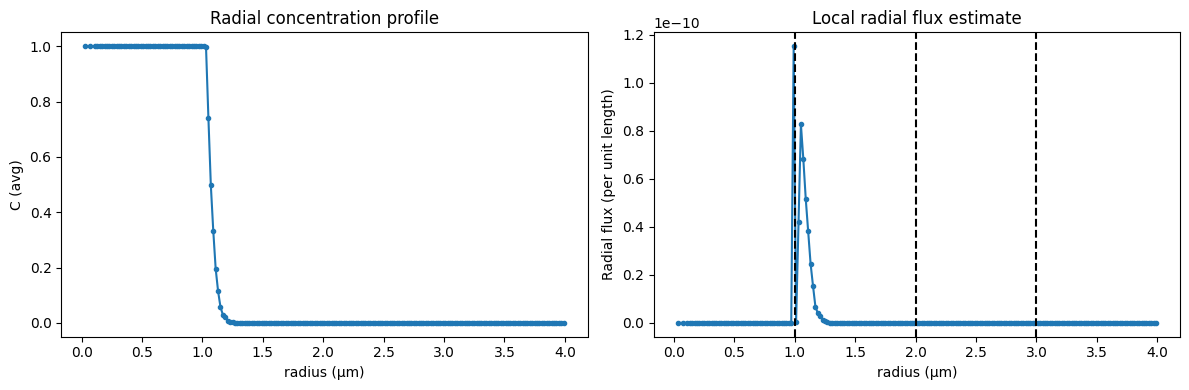

In [12]:
# myelin_fipy_flux_compare.py
import numpy as np
import matplotlib.pyplot as plt
from fipy import Grid2D, CellVariable, TransientTerm, DiffusionTerm, Viewer

# ---------------------------
# PARAMETERS
# ---------------------------
L_domain = 10e-6      # domain size (m) - domain is square L_domain x L_domain
nx = 200              # cells in x
ny = 200              # cells in y
L_axial = 1.0         # axial length (m) used in analytic formula (use 1 for per-unit-length)

# Radii (meters) - concentric shells
r0 = 1.0e-6   # inner boundary (core radius)
r1 = 2.0e-6   # shell 1 outer
r2 = 3.0e-6   # shell 2 outer
r3 = 4.0e-6   # outer boundary (domain radius for BC)

# Diffusion coefficients in each radial region (m^2/s)
D_core = 1e-9
D_shell1 = 1e-12
D_shell2 = 5e-13

# Boundary concentrations
C_inner = 1.0
C_outer = 0.0

# Time stepping parameters (we'll time-step to steady state)
dt = 1e-6
nsteps = 2000

# ---------------------------
# MESH and RADIAL MASKS
# ---------------------------
mesh = Grid2D(dx=L_domain/nx, dy=L_domain/ny, nx=nx, ny=ny)
x, y = mesh.cellCenters  # vectors of cell center coords
xc = np.array(x)         # convert to numpy arrays
yc = np.array(y)

# center the circular geometry in the square domain
x0 = L_domain / 2.0
y0 = L_domain / 2.0
r = np.sqrt((xc - x0)**2 + (yc - y0)**2)

# Masks for regions
core_mask = (r <= r0)
shell1_mask = (r > r0) & (r <= r1)
shell2_mask = (r > r1) & (r <= r2)
outside_mask = (r > r2) & (r <= r3)  # we will set outer BC at r3

# Create a FiPy CellVariable for spatially varying diffusion coefficient
D_values = np.zeros_like(r)
D_values[core_mask] = D_core
D_values[shell1_mask] = D_shell1
D_values[shell2_mask] = D_shell2
# Outside region set to the largest D (or same as shell2) to avoid singularities
D_values[outside_mask] = D_shell2

D = CellVariable(mesh=mesh, name='D', value=D_values)

# ---------------------------
# CONCENTRATION VARIABLE and BCs
# ---------------------------
C = CellVariable(mesh=mesh, name='C', value=0.0)

# Apply Dirichlet constraints:
# - Inner: set C=1 for cells inside core_mask (approximate inner radius BC)
# - Outer: set C=0 for cells with r >= r3*0.999 (approximate outer boundary)
C.constrain(C_inner, where=core_mask)
C.constrain(C_outer, where=(r >= r3))

# ---------------------------
# EQUATION (Transient -> steady)
# ---------------------------
eq = TransientTerm() == DiffusionTerm(coeff=D)

# Optional viewer (works if you have X server)
try:
    viewer = Viewer(vars=(C,), datamin=0.0, datamax=1.0)
except Exception:
    viewer = None

# Time-stepping to steady state
for step in range(nsteps):
    eq.solve(var=C, dt=dt)
    if viewer and (step % 200 == 0):
        viewer.plot()
print("Time-stepping finished.")

# ---------------------------
# POSTPROCESS: radial binning to compute numerical flux
# ---------------------------
# Create radial bins from a small radius (just outside inner BC) to r3
nbins = 200
r_bins = np.linspace(0, r3, nbins+1)
r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
dr = r_bins[1] - r_bins[0]

# Average concentration and D in each annulus
Cvals = np.array(C.value)     # values at cell centers
Dvals = np.array(D.value)

C_radial_avg = np.zeros(nbins)
D_radial_avg = np.zeros(nbins)
count = np.zeros(nbins)

for i_bin in range(nbins):
    mask_bin = (r >= r_bins[i_bin]) & (r < r_bins[i_bin+1])
    if np.any(mask_bin):
        C_radial_avg[i_bin] = Cvals[mask_bin].mean()
        D_radial_avg[i_bin] = Dvals[mask_bin].mean()
        count[i_bin] = mask_bin.sum()
    else:
        C_radial_avg[i_bin] = np.nan
        D_radial_avg[i_bin] = np.nan

# Remove empty bins
valid = ~np.isnan(C_radial_avg)
r_centers = r_centers[valid]
C_radial_avg = C_radial_avg[valid]
D_radial_avg = D_radial_avg[valid]

# Compute dC/dr (numerical derivative w.r.t r)
dCdr = np.gradient(C_radial_avg, r_centers)

# Radial flux density (per unit axial length) J(r) = -2*pi * r * D(r) * dC/dr
# Total flux (per unit axial length) should be approximately constant; evaluate near inner radius
J_radial = -2.0 * np.pi * r_centers * D_radial_avg * dCdr

# Estimate total flux as average over a small radial range just outside r0
probe_mask = (r_centers > r0) & (r_centers < (r0 + 0.5*(r1 - r0)))
J_numeric = np.nanmean(J_radial[probe_mask])

print("Numerical flux (per unit axial length) J_numeric =", J_numeric)

# ---------------------------
# ANALYTIC FLUX (resistance-sum)
# ---------------------------
# We set Ca = 1 (at r0) and Cb = 0 (at r3)
Ca, Cb = C_inner, C_outer
# Define the radial interfaces and D_i arrays used in analytic formula
r_interfaces = np.array([r0, r1, r2, r3])  # r0..r3
D_layers = np.array([D_core, D_shell1, D_shell2])  # three layers between r0-r1, r1-r2, r2-r3

# Compute denominator sum_{i} (1/D_i) * ln(r_i / r_{i-1})
den = 0.0
for i in range(len(D_layers)):
    den += (1.0 / D_layers[i]) * np.log(r_interfaces[i+1] / r_interfaces[i])

J_analytic = 2.0 * np.pi * L_axial * (Ca - Cb) / den
print("Analytic flux (per unit axial length) J_analytic =", J_analytic)

# Relative error
rel_err = (J_numeric - J_analytic) / J_analytic
print("Relative error (numeric vs analytic): {:.3e}".format(rel_err))

# ---------------------------
# PLOTTING radial profile and flux
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(r_centers * 1e6, C_radial_avg, '-o', markersize=3)
axes[0].set_xlabel('radius (µm)')
axes[0].set_ylabel('C (avg)')
axes[0].set_title('Radial concentration profile')

axes[1].plot(r_centers * 1e6, J_radial, '-o', markersize=3)
axes[1].axvline(r0 * 1e6, color='k', linestyle='--')
axes[1].axvline(r1 * 1e6, color='k', linestyle='--')
axes[1].axvline(r2 * 1e6, color='k', linestyle='--')
axes[1].set_xlabel('radius (µm)')
axes[1].set_ylabel('Radial flux (per unit length)')
axes[1].set_title('Local radial flux estimate')

plt.tight_layout()
plt.show()
